In [1]:
%matplotlib widget

Trying to replicate the following research piece:
https://www.federalreserve.gov/econres/notes/feds-notes/index-of-common-inflation-expectations-20200902.htm
Essentially to create an indicator of inflation expectations that reads through the noise of various forward looking metrics.

This Notebook is part of a group of notebooks that save results as Pickle files and are imported below.
One needs to run the prior notebooks in order to prepare / preprocess the data and get up to date numbers.
Below we explore them in more detail and side by side.

# Inflation expectations as a hidden factors model

### Importing data and observing it altogether: preliminary considerations
The below tries to replicate the research piece from the FED chaps mentioned above.
Notes for when you try to do a full comparison of what you have available vs. what is available 
We do not have access to the entirety of the data, and some measures are market implied whereas other ones are actual expectations, survey based.
Some data may be available quarterly and some monthly, hence it kind of makes sense to keep using both but roll forward the quarterly data as long as needed...

In [2]:
# load libraries
import pandas as pd
import statsmodels.api as sm
from matplotlib import pyplot as plt
from statsmodels.multivariate.pca import PCA

# load data from existing pd.pkl files
mich = pd.read_pickle('michigan_dataset.pd.pkl')
spf = pd.read_pickle('spf_dataset.pd.pkl')
tips = pd.read_pickle('tips_dataset.pd.pkl')

In [3]:
mich.tail()

,mich_short_mean,mich_short_25,mich_short_75,mich_medium_mean,mich_medium_25,mich_medium_75
Date,,,,,,
2023-07-31,5.0,0.7,5.4,4.3,1.6,5.0
2023-08-31,5.6,1.4,6.4,4.3,1.4,5.0
2023-09-30,5.3,0.5,6.5,3.5,1.2,4.6
2023-10-31,6.3,1.4,7.4,4.5,1.5,5.0
2023-11-30,6.1,1.9,7.6,4.8,1.8,5.3


In [4]:
spf.tail()

,spf_cpi1y,spf_cpi5y,spf_cpi10y,spf_cpi5y5y,spf_pce1y,spf_pce5y,spf_pce10y,spf_pce5y5y
2022-12-31,3.669335,3.8948,3.0650,2.241828,3.250721,3.2761,2.6134,1.954952
2023-03-31,2.972462,2.6546,2.4402,2.226248,2.670856,2.3679,2.2280,2.088291
2023-06-30,2.920303,2.6058,2.4060,2.206589,2.792950,2.4137,2.1890,1.964793
2023-09-30,2.695124,2.6826,2.4169,2.151888,2.512892,2.4819,2.2521,2.022815
2023-12-31,2.570410,2.6248,2.4318,2.239163,2.355114,2.4232,2.2300,2.037164


In [5]:
tips.tail()

,tips_5y,tips_5y5y,tips_10y
2023-08-31,2.239565,2.430870,2.335217
2023-09-30,2.253500,2.430500,2.342000
2023-10-31,2.310000,2.462381,2.386190
2023-11-30,2.247143,2.361429,2.304286
2023-12-31,2.126875,2.253125,2.190000


Now the above data is correctly once a month, has got monthly index but may well start in different places.
So first thing, I create a merged DataFrame with all data in one place (with same index), then roll forward the observations (so that you can use most recent data or carry forward earlier one).

In [6]:
all_data = pd.concat([mich, spf, tips], axis=1)
all_data = all_data.dropna(how='all')
all_data_idx = pd.date_range(start=all_data.index.min(), end=all_data.index.max(), freq='M')
all_data = all_data.reindex(all_data_idx)
all_data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 539 entries, 1979-02-28 to 2023-12-31
Freq: M
Data columns (total 17 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mich_short_mean   446 non-null    float64
 1   mich_short_25     446 non-null    float64
 2   mich_short_75     446 non-null    float64
 3   mich_medium_mean  446 non-null    float64
 4   mich_medium_25    446 non-null    float64
 5   mich_medium_75    446 non-null    float64
 6   spf_cpi1y         170 non-null    float64
 7   spf_cpi5y         74 non-null     float64
 8   spf_cpi10y        129 non-null    float64
 9   spf_cpi5y5y       74 non-null     float64
 10  spf_pce1y         68 non-null     float64
 11  spf_pce5y         68 non-null     float64
 12  spf_pce10y        68 non-null     float64
 13  spf_pce5y5y       68 non-null     float64
 14  tips_5y           252 non-null    float64
 15  tips_5y5y         252 non-null    float64
 16  tips_10y         

From the above, we can see that the most data appear in the Michigan surveys, whereas the Survey of Professional Forecasters only has far less monthly data available in selected categories (e.g. the PCE estimates). The TIPS data sits somewhere in the middle.

As we also have "variations" of the same data, I prefer to select a few of these metrics only:

- all data from the Michigan dataset
- CPI and PCE data on 5y and 5y5y
- TIPS data on 5y and 5y5y

In [7]:
cols = ["mich_short_mean", "mich_short_25", "mich_short_75", 
        "mich_medium_mean", "mich_medium_25", "mich_medium_75",
        "spf_cpi5y", "spf_cpi5y5y", "spf_pce5y", "spf_pce5y5y",
        "tips_5y", "tips_5y5y"]
data = all_data[cols]
data.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 539 entries, 1979-02-28 to 2023-12-31
Freq: M
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   mich_short_mean   446 non-null    float64
 1   mich_short_25     446 non-null    float64
 2   mich_short_75     446 non-null    float64
 3   mich_medium_mean  446 non-null    float64
 4   mich_medium_25    446 non-null    float64
 5   mich_medium_75    446 non-null    float64
 6   spf_cpi5y         74 non-null     float64
 7   spf_cpi5y5y       74 non-null     float64
 8   spf_pce5y         68 non-null     float64
 9   spf_pce5y5y       68 non-null     float64
 10  tips_5y           252 non-null    float64
 11  tips_5y5y         252 non-null    float64
dtypes: float64(12)
memory usage: 54.7 KB


In [24]:
data_pca = data.ffill()
data_pca.tail()

,mich_short_mean,mich_short_25,mich_short_75,mich_medium_mean,mich_medium_25,mich_medium_75,spf_cpi5y,spf_cpi5y5y,spf_pce5y,spf_pce5y5y,tips_5y,tips_5y5y
2023-08-31,5.6,1.4,6.4,4.3,1.4,5.0,2.6058,2.206589,2.4137,1.964793,2.239565,2.430870
2023-09-30,5.3,0.5,6.5,3.5,1.2,4.6,2.6826,2.151888,2.4819,2.022815,2.253500,2.430500
2023-10-31,6.3,1.4,7.4,4.5,1.5,5.0,2.6826,2.151888,2.4819,2.022815,2.310000,2.462381
2023-11-30,6.1,1.9,7.6,4.8,1.8,5.3,2.6826,2.151888,2.4819,2.022815,2.247143,2.361429
2023-12-31,6.1,1.9,7.6,4.8,1.8,5.3,2.6248,2.239163,2.4232,2.037164,2.126875,2.253125


### Principal Component Analysis
Now, I shall first run a PCA analysis on the above "cleaned up" data, to see how many actual factors appear in the data.
First let's plot the entirety of the dataset and see when that data actually starts... Different start dates for each column...
Principal Component Analysis does not allow you to have missing observations, hence the PCA model used below will have to actually drop it.
It will then be visible from when the data has been considered from the output of the components.

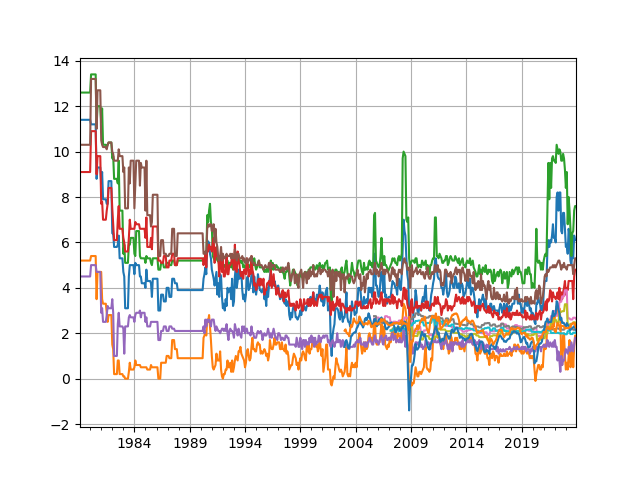

In [9]:
ax = data_pca.plot(grid=True, legend=False);

In [10]:
# here i suggest that the entire row (i.e. the entire observation month) is dropped from the PCA to be run.
pca_model = PCA(data_pca, standardize=True, demean=True, missing='drop-row')

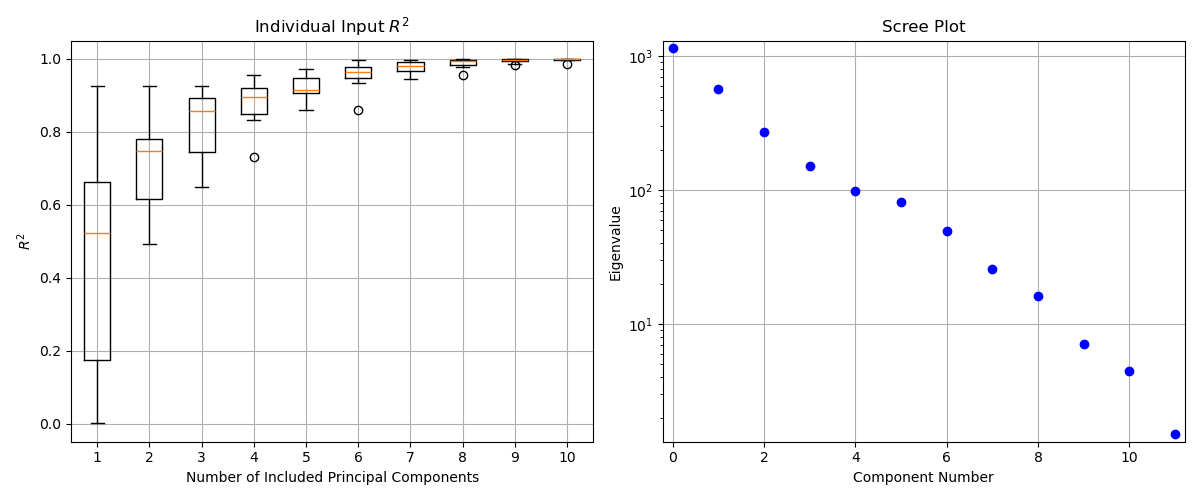

In [11]:
# these graphics below are essentially pre-made and are only useful to understand the number of components that the above PCA suggests
fig, ax = plt.subplots(1,2, figsize=(12,5));
pca_model.plot_rsquare(ax=ax[0]);
ax[0].grid(True);
pca_model.plot_scree(log_scale=True, ax=ax[1]);
ax[1].grid(True);

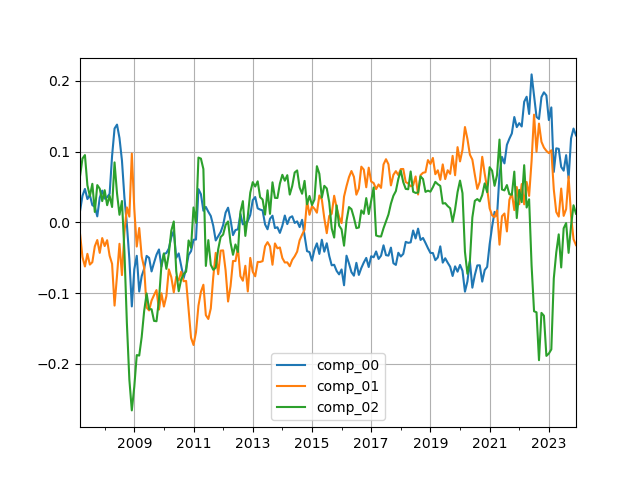

In [12]:
# From the two plots above, it appears that 2 or 3 factors are really driving the variations of the observed variables.
# How do these factors look like over time? here we go below.
pca_model.factors.iloc[:, :3].plot(grid=True);

Now, this is interesting... there appear to be 3 real factors (in the demeaned and standardised data set) but if you see above **comp_01** and **comp_02** somehow recently appear to be behaving similarly. It will be interesting to try to model this in a Dynamic Factor approach via Kalman Filter.

Let's also look at the ACF plots for the length of the autoregressions.

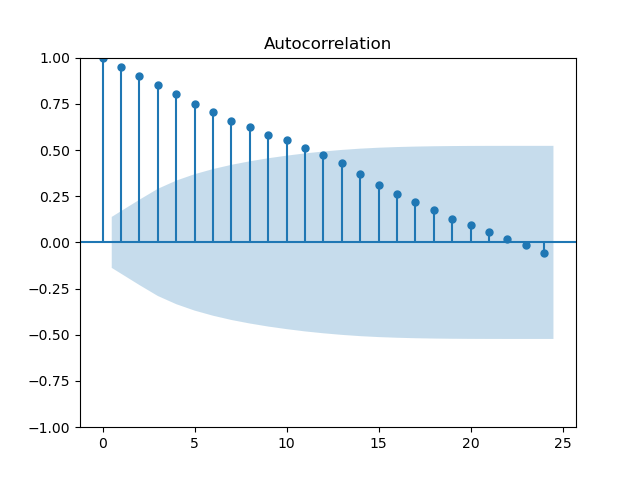

In [13]:
fig, ax = plt.subplots();
sm.graphics.tsa.plot_acf(pca_model.factors.iloc[:,0], ax=ax);

## Kalman Filter, or Hidden Dynamic Factor model

The model used in the FED Index of Common Inflation Expectations is actually not *fully* specified in the note. They state that they use de-meaned and normalised data and they use a single factor. It's not clear what dynamics they use for error terms, but I guess probably no error term is modelled through a factor.

Using a Kalman Filter, you can make a maximum likelihood estimate of the factors, and you can choose a specific autoregression order for the factors. You can also use an autoregressive term for the error.
Notably, the Kalman Filter does NOT need to have de-meaned and standardised data at hand, but I can guess why you'd want to use in some circumstances de-meaned and standardised data.
In my case, I want to guess a real factor and also use a dynamic model for the error terms.
Let's see where that goes first by creating a reasonably complicated model.
In terms of order of the model, it's a bit of a guess work as here we are dealing with monthly data but the autoregressions above give some hints that probably something like 6 lags make sense. So to start with, I'd go for:

- order 6 autoregression on the factor (2 quarters) from the ACF plot above, as a minimum
- autoregression on the error term (1 quarter)
- 2 or 3 factors model

This way, I start from a reasonably complex model, that has to look at a number of variables together, with monthly frequency. In addition, I take into account 2 or 3 factors (that likely will represent short term and longer term inflation expectations or variations thereof).
It's easier to start with 2 and see if there appears to be a meaningful explanation of the factors and the way they look.
The paper also seems to only take into consideration quarterly data and only one factor but they do highlight the drawbacks of the one factor approach...
Let's start with trying to reconstruct their model as much as possible first...

### Reconstructing the "FED CIE" (or sort of)

Let's start with trying to replicate a single factor, quarterly model from about 1989. This is what I think they do, although they don't overclarify the parameters of the model.
What is certain is that the data I use is in part different, but based on the same starting point, and in part I simply don't have access to that data.

In [14]:
factors = ["single"]
factor_orders = 4 #assumption? unclear what the order is...
standardize = True # they state that the standardize input variables
idiosyncratic_ar1 = False # assumption

data_from = '1989'
cie_cols = ["mich_short_mean", "mich_short_25", "mich_short_75", 
            "mich_medium_mean", "mich_medium_25", "mich_medium_75",
            "spf_cpi5y", "spf_cpi5y5y", "spf_pce5y", "spf_pce5y5y",
            "tips_5y", "tips_5y5y"]

# resample the data we have available to quarterly and use "mean" to come up with quarterly value from monthly values where relevant
data_cie = data.loc[data_from:, cie_cols].resample('Q').mean()

mod_dfm_cie = sm.tsa.DynamicFactorMQ(data_cie, factors=factors, factor_orders=factor_orders, standardize=standardize, idiosyncratic_ar1=idiosyncratic_ar1)
print(mod_dfm_cie.summary())

                         Model Specification: Dynamic Factor Model                         
Model:                Dynamic Factor Model   # of observed variables:                    12
                   + 1 factors in 1 blocks   # of factors:                                1
                       + iid idiosyncratic   Idiosyncratic disturbances:                iid
Sample:                1989-03-31 00:00:00   Standardize variables:                    True
                     - 2023-12-31 00:00:00                                                 
Observed variables / factor loadings
   Dep. variable     single
---------------------------
 mich_short_mean       X   
   mich_short_25       X   
   mich_short_75       X   
mich_medium_mean       X   
  mich_medium_25       X   
  mich_medium_75       X   
       spf_cpi5y       X   
     spf_cpi5y5y       X   
       spf_pce5y       X   
     spf_pce5y5y       X   
         tips_5y       X   
       tips_5y5y       X   
    Factor blocks: 

In [15]:
mod_dfm_cie_res = mod_dfm_cie.fit(maxiter=2000, tolerance=1e-6, disp=False);

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1870: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.DataFrame(self.endog).interpolate().fillna(method='backfill'),


In [16]:
print(mod_dfm_cie_res.summary())

                                  Dynamic Factor Results                                  
Dep. Variable:     "mich_short_mean", and 11 more   No. Observations:                  140
Model:                       Dynamic Factor Model   Log Likelihood               -1396.314
                          + 1 factors in 1 blocks   AIC                           2850.628
                              + iid idiosyncratic   BIC                           2935.936
Date:                            Sat, 23 Dec 2023   HQIC                          2885.295
Time:                                    12:47:17   EM Iterations                      118
Sample:                                03-31-1989                                         
                                     - 12-31-2023                                         
Covariance Type:                     Not computed                                         
        Observation equation:         
Factor loadings:     single       var.
------------

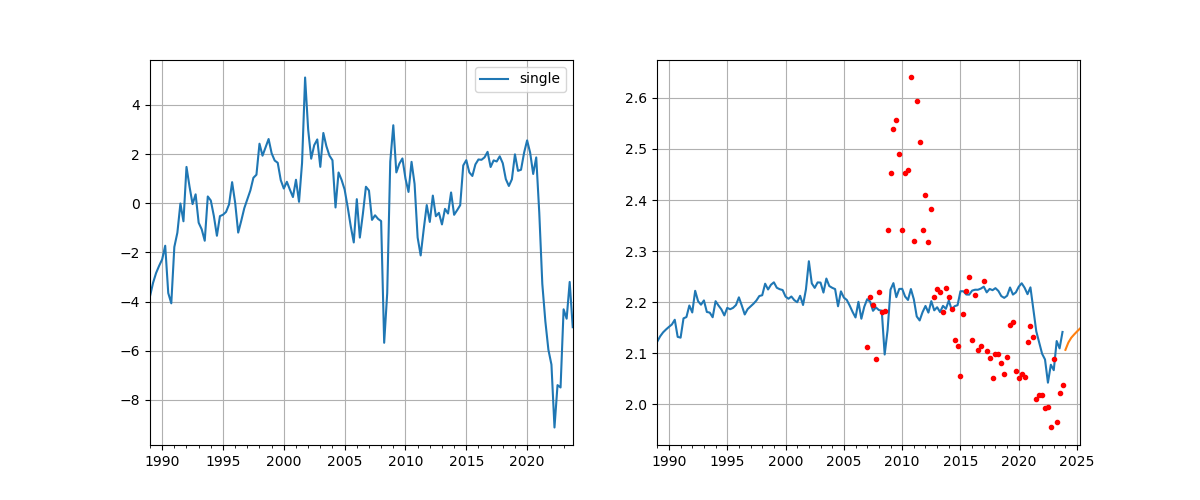

In [17]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5));
#mod_dfm_cie_res.plot_coefficients_of_determination();
mod_dfm_cie_res.factors['filtered'].loc[data_from:].plot(grid=True, ax=ax[0]);
dfm_cie_filtered_results = mod_dfm_cie_res.predict()
dfm_cie_predictions = mod_dfm_cie_res.forecast(6)
dfm_cie_filtered_results.loc[:, 'spf_pce5y5y'].plot(grid=True, ax=ax[1]);
data_cie.loc[:, 'spf_pce5y5y'].plot(grid=True, ax=ax[1], style='r.');
dfm_cie_predictions.loc[:, 'spf_pce5y5y'].plot(grid=True, ax=ax[1]);

### Creating a two factor model, based on monthly observations

If I assume that the short dated stuff only depends on short dated factor and the long dated one only on long dated factor, I am essentially creating two separate single factor models. 
Hence I choose to consider the short dated factor to drive only short dated output, but the long dated factor to have influence on both short dated and long dated types of observations.

In [25]:
factors = {
    "mich_short_mean": ["short","long"],
    "mich_short_25": ["short","long"],
    "mich_short_75": ["short","long"],
    "mich_medium_mean": ["long"],
    "mich_medium_25": ["long"],
    "mich_medium_75": ["long"],
    "spf_cpi5y": ["short","long"],
    "spf_cpi5y5y": ["long"],
    "spf_pce5y": ["short","long"],
    "spf_pce5y5y": ["long"],
    "tips_5y": ["short","long"],
    "tips_5y5y": ["long"],
}
factor_orders = {
    "short": 6,
    "long": 12
}
factor_multiplicities = None
standardize = True
idiosyncratic_ar1 = False

data_from = '1989'
data_to = None
cols = ["mich_short_mean", "mich_short_25", "mich_short_75", 
            "mich_medium_mean", "mich_medium_25", "mich_medium_75",
            "spf_cpi5y", "spf_cpi5y5y", "spf_pce5y", "spf_pce5y5y",
            "tips_5y", "tips_5y5y"]

mod_dfm = sm.tsa.DynamicFactorMQ(data.loc[data_from:data_to, cols], factors=factors, \
                                 factor_orders=factor_orders, factor_multiplicities=factor_multiplicities, \
                                 standardize=standardize, idiosyncratic_ar1=idiosyncratic_ar1)
print(mod_dfm.summary())

                         Model Specification: Dynamic Factor Model                         
Model:                Dynamic Factor Model   # of observed variables:                    12
                   + 2 factors in 2 blocks   # of factor blocks:                          2
                       + iid idiosyncratic   Idiosyncratic disturbances:                iid
Sample:                1989-01-31 00:00:00   Standardize variables:                    True
                     - 2023-12-31 00:00:00                                                 
 Observed variables / factor loadings 
   Dep. variable      short       long
--------------------------------------
 mich_short_mean        X          X  
   mich_short_25        X          X  
   mich_short_75        X          X  
mich_medium_mean                   X  
  mich_medium_25                   X  
  mich_medium_75                   X  
       spf_cpi5y        X          X  
     spf_cpi5y5y                   X  
       spf_pce5y   

In [26]:
mod_dfm_res = mod_dfm.fit(maxiter=2000, tolerance=1e-5, disp=False)

/opt/conda/lib/python3.11/site-packages/statsmodels/tsa/statespace/dynamic_factor_mq.py:1870: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  pd.DataFrame(self.endog).interpolate().fillna(method='backfill'),


In [27]:
print(mod_dfm_res.summary())

                                  Dynamic Factor Results                                  
Dep. Variable:     "mich_short_mean", and 11 more   No. Observations:                  420
Model:                       Dynamic Factor Model   Log Likelihood               -2569.440
                          + 2 factors in 2 blocks   AIC                           5238.881
                              + iid idiosyncratic   BIC                           5440.894
Date:                            Sat, 23 Dec 2023   HQIC                          5318.726
Time:                                    12:57:13   EM Iterations                      378
Sample:                                01-31-1989                                         
                                     - 12-31-2023                                         
Covariance Type:                     Not computed                                         
              Observation equation:              
Factor loadings:      short       long  

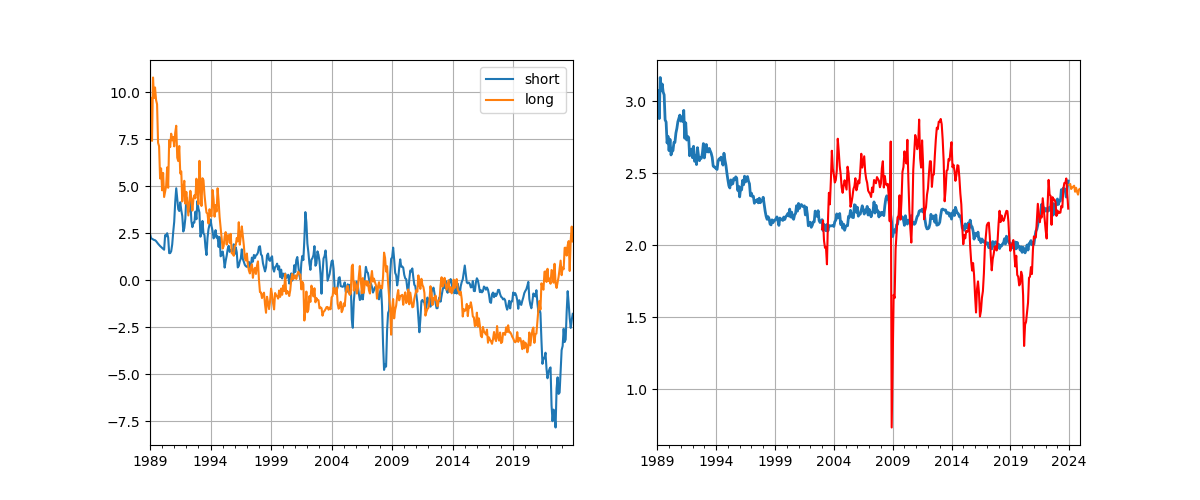

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5));
variable_of_interest = 'tips_5y5y'
#mod_dfm_res.plot_coefficients_of_determination(ax=ax[0]);
mod_dfm_res.factors['filtered'].loc[data_from:].plot(grid=True, ax=ax[0]);
dfm_filtered_results = mod_dfm_res.predict()
dfm_predictions = mod_dfm_res.forecast(12)
dfm_filtered_results.loc[data_from:, variable_of_interest].plot(grid=True, ax=ax[1], linewidth=2);
data.loc[data_from:, variable_of_interest].plot(grid=True, ax=ax[1], style='r-');
dfm_predictions.loc[data_from:, variable_of_interest].plot(grid=True, ax=ax[1]);

In [29]:
data.tail(3)

,mich_short_mean,mich_short_25,mich_short_75,mich_medium_mean,mich_medium_25,mich_medium_75,spf_cpi5y,spf_cpi5y5y,spf_pce5y,spf_pce5y5y,tips_5y,tips_5y5y
2023-10-31,6.3,1.4,7.4,4.5,1.5,5.0,NaN,NaN,NaN,NaN,2.310000,2.462381
2023-11-30,6.1,1.9,7.6,4.8,1.8,5.3,NaN,NaN,NaN,NaN,2.247143,2.361429
2023-12-31,NaN,NaN,NaN,NaN,NaN,NaN,2.6248,2.239163,2.4232,2.037164,2.126875,2.253125


In [30]:
dfm_predictions

,mich_short_mean,mich_short_25,mich_short_75,mich_medium_mean,mich_medium_25,mich_medium_75,spf_cpi5y,spf_cpi5y5y,spf_pce5y,spf_pce5y5y,tips_5y,tips_5y5y
2024-01-31,5.479296,1.915740,7.055946,4.156406,1.835337,5.071898,2.730558,2.419967,2.392152,2.196259,2.434108,2.418383
2024-02-29,5.448072,1.895363,7.011273,4.176846,1.842714,5.088104,2.725639,2.420444,2.387348,2.196288,2.427875,2.424339
2024-03-31,5.257075,1.823172,6.823885,4.056767,1.799374,4.992900,2.678129,2.417641,2.349415,2.196118,2.360415,2.389350
2024-04-30,5.304184,1.839602,6.867850,4.092817,1.812385,5.021482,2.690305,2.418483,2.358996,2.196169,2.377824,2.399854
2024-05-31,5.330304,1.849141,6.892932,4.110794,1.818874,5.035735,2.696913,2.418902,2.364238,2.196194,2.387236,2.405092
2024-06-30,5.351106,1.854601,6.909406,4.135103,1.827648,5.055008,2.702885,2.419469,2.368761,2.196229,2.395927,2.412176
2024-07-31,5.136632,1.775495,6.702192,3.991108,1.775676,4.940843,2.648885,2.416109,2.325846,2.196025,2.319078,2.370218
2024-08-31,5.241378,1.808878,6.794795,4.085973,1.809915,5.016056,2.677002,2.418323,2.347661,2.196159,2.359548,2.397860
2024-09-30,5.087134,1.750416,6.643199,3.989758,1.775188,4.939773,2.638688,2.416077,2.317054,2.196023,2.305158,2.369825
2024-10-31,4.974070,1.706803,6.530833,3.922783,1.751015,4.886672,2.610856,2.414514,2.294742,2.195928,2.265716,2.350310
